In [1]:
import os
import pprint
import tempfile
import urllib
import numpy as np
import pandas as pd
import absl
import tensorflow as tf
import tensorflow_model_analysis as tfma
import tfx
from tfx.components import CsvExampleGen, Evaluator, ExampleValidator, Pusher, ResolverNode, SchemaGen, StatisticsGen, Trainer,Transform, BulkInferrer
from tfx.components.base import executor_spec 
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata, pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import trainer_pb2, pusher_pb2, bulk_inferrer_pb2, example_gen_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing
from tfx.utils.dsl_utils import external_input

import module

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()
absl.logging.set_verbosity(absl.logging.INFO)

_serving_model_dir = os.path.join(os.getcwd(), 'serving_model')
_context_dir = os.path.join(os.getcwd(), 'context')
_data_dir = module.DATA_DIR

context = InteractiveContext(pipeline_root=_context_dir)

# ExampleGen

In [2]:
example_gen = CsvExampleGen(input=external_input(_data_dir))
context.run(example_gen)

# Print examples
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'train')
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example.features)

Instructions for updating:
external_input is deprecated, directly pass the uri to ExampleGen.
INFO:absl:Running driver for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:Running executor for CsvExampleGen
INFO:absl:Generating examples.


INFO:absl:Processing input csv data /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/../../data/titanic/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Running publisher for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized
feature {
  key: "age"
  value {
    float_list {
      value: 0.916700005531311
    }
  }
}
feature {
  key: "boat"
  value {
    bytes_list {
      value: "11"
    }
  }
}
feature {
  key: "body"
  value {
    int64_list {
    }
  }
}
feature {
  key: "cabin"
  value {
    bytes_list {
      value: "C22 C26"
    }
  }
}
feature {
  key: "embarked"
  value {
    bytes_list {
      value: "S"
    }
  }
}
feature {
  key: "fare"
  value {
    float_list {
      value: 151.5500030517578
    }
  }
}
feature {
  key: "home.dest"
  value {
    bytes_list {
      value: "Montreal  PQ   Chesterville  ON"
    }
  }
}
feature {
  key: "name"
  value {
    bytes_list {
      value: "Allison  Master. Hudson Trevor"
    }
  }
}
feature {
  key: "pa

# StatisticsGen

In [3]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)
context.show(statistics_gen.outputs['statistics'])

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for StatisticsGen
INFO:absl:Generating statistics for split train.
INFO:absl:Statistics for split train written to /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/StatisticsGen/statistics/971/train.
INFO:absl:Generating statistics for split eval.
INFO:absl:Statistics for split eval written to /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/StatisticsGen/statistics/971/eval.
INFO:absl:Running publisher for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


# SchemaGen

In [4]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen)
context.show(schema_gen.outputs['schema'])

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for SchemaGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for SchemaGen
INFO:absl:Processing schema from statistics for split train.
INFO:absl:Processing schema from statistics for split eval.
INFO:absl:Schema written to /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/SchemaGen/schema/972/schema.pbtxt.
INFO:absl:Running publisher for SchemaGen
INFO:absl:MetadataStore with DB connection initialized


,Type,Presence,Valency,Domain
Feature name,,,,
'boat',STRING,required,,'boat'
'cabin',BYTES,required,,-
'embarked',STRING,required,,'embarked'
'home.dest',BYTES,required,,-
'name',BYTES,required,single,-
'sex',STRING,required,single,'sex'
'ticket',BYTES,required,single,-
'age',FLOAT,required,,-
'body',INT,required,,-


/home/borlogh/anaconda3/envs/stovell/lib/python3.8/site-packages/tensorflow_data_validation/utils/display_util.py:151: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Values
Domain,
'boat',"'1', '10', '11', '12', '13', '13 15', '13 15 B', '14', '15', '15 16', '16', '2', '3', '4', '5', '5 7', '6', '7', '8', '8 10', '9', 'A', 'B', 'C', 'C D', 'D', '5 9'"
'embarked',"'C', 'Q', 'S'"
'sex',"'female', 'male'"


# Transform

In [5]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file="module_tfx.py")
context.run(transform)


# Print transformed data
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'train')

tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

for tfrecord in dataset.take(1):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

INFO:absl:Running driver for Transform
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Transform
INFO:absl:Analyze the 'train' split and transform all splits when splits_config is not set.
Instructions for updating:
Schema is a deprecated, use schema_utils.schema_from_feature_spec to create a `Schema`
INFO:absl:Loading module_tfx.py because it has not been loaded before.
INFO:absl:module_tfx.py is already loaded.
INFO:absl:Feature boat has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature cabin has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature embarked has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature home.dest has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature name has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature sex has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature ticket has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature age has no shape. Setting to VarLenSpars

# Trainer

In [6]:
trainer = Trainer(
    module_file="module_tfx.py",
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(num_steps=module.NUM_STEPS),
    eval_args=trainer_pb2.EvalArgs(num_steps=module.NUM_STEPS))
context.run(trainer)

model_run_artifact_dir = trainer.outputs['model_run'].get()[0].uri
pd.read_csv(os.path.join(model_run_artifact_dir,"metrics_train.csv"))

INFO:absl:Running driver for Trainer
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Trainer
INFO:absl:Train on the 'train' split when train_args.splits is not set.
INFO:absl:Evaluate on the 'eval' split when eval_args.splits is not set.
INFO:absl:module_tfx.py is already loaded.
INFO:absl:Training model.
INFO:absl:Feature age_pclass_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature age_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature boat_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature cabin_count_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature embarked_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature family_size_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature fare_per_person_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature fare_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature home.dest_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature is_alone_xf has a shap

,epoch,auc,binary_accuracy,loss,val_auc,val_binary_accuracy,val_loss
0,0,0.931269,0.853826,0.392670,0.978494,0.916050,0.293244
1,1,0.992978,0.948398,0.212319,0.990071,0.955749,0.198805
2,2,0.996912,0.978948,0.139088,0.991782,0.967398,0.152415
3,3,0.997656,0.985173,0.100959,0.992522,0.965023,0.127574
4,4,0.998134,0.985272,0.078874,0.992205,0.965049,0.113270
5,5,0.998508,0.985222,0.064995,0.992289,0.965098,0.105584
6,6,0.998803,0.985148,0.055883,0.991897,0.965074,0.101538
7,7,0.999026,0.985348,0.049354,0.990835,0.967323,0.100333
8,8,0.999208,0.987098,0.044282,0.991038,0.962698,0.101067
9,9,0.999320,0.988223,0.040561,0.991175,0.962773,0.103489


In [7]:
%load_ext tensorboard
%tensorboard --logdir {model_run_artifact_dir}
# http://localhost:6006

# Evaluator

In [8]:

# Get the last blessed model to use as baseline
model_resolver = ResolverNode(
      instance_name='latest_blessed_model_resolver',
      resolver_class=latest_blessed_model_resolver.LatestBlessedModelResolver,
      model=Channel(type=Model),
      model_blessing=Channel(type=ModelBlessing))
context.run(model_resolver)

eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(label_key=module.LABEL_KEY)
    ],
    metrics_specs=module.METRICS_SPECS,
    slicing_specs=module.SLICING_SPECS)

evaluator = Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    baseline_model=model_resolver.outputs['model'],
    eval_config=eval_config)
context.run(evaluator)

INFO:absl:Running driver for ResolverNode.latest_blessed_model_resolver
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running publisher for ResolverNode.latest_blessed_model_resolver
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running driver for Evaluator
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Evaluator
        please use "has_baseline" instead.
INFO:absl:Request was made to ignore the baseline ModelSpec and any change thresholds. This is likely because a baseline model was not provided: updated_config=
model_specs {
  label_key: "survived"
}
slicing_specs {
}
metrics_specs {
  metrics {
    class_name: "BinaryAccuracy"
    threshold {
      value_threshold {
        lower_bound {
          value: 0.9
        }
      }
    }
  }
  metrics {
    class_name: "AUC"
  }
}

INFO:absl:Using /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/Trainer/model/974/serving_model_dir as  model.
INFO:absl:

ExecutionResult(
    component_id: Evaluator
    execution_id: 976
    outputs:
        evaluation: Channel(
            type_name: ModelEvaluation
            artifacts: [Artifact(artifact: id: 1205
        type_id: 19
        uri: "/home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/Evaluator/evaluation/976"
        custom_properties {
          key: "name"
          value {
            string_value: "evaluation"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Evaluator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 19
        name: "ModelEvaluation"
        )]
        )
        blessing: Channel(
            type_name: ModelBlessing
            artifacts: [Artifact(artifact: id: 1206
        type_id: 20
        uri: "/home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/Evaluator/blessing/976"
        custom_properties {
          key: "blessed"
          value {
            int_value: 1
          }
        }
        custom_properties {
          key: "current_model"
          value {
            string_value: "/home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/Trainer/model/974"
          }
        }
        custom_properties {
          key: "current_model_id"
          value {
            int_value: 1203
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "blessing"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Evaluator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 20
        name: "ModelBlessing"
        )]
        ))

In [9]:
output_path = evaluator.outputs['evaluation'].get()[0].uri
eval_result = tfma.load_eval_result(output_path)

print("Validation Result\n",tfma.load_validation_result(output_path))
print("Metrics\n",eval_result.slicing_metrics)
tfma.view.render_slicing_metrics(eval_result)


Validation Result
 validation_ok: true
validation_details {
  slicing_details {
    slicing_spec {
    }
    num_matching_slices: 1
  }
}

Metrics
 [((), {'': {'': {'binary_accuracy': {'doubleValue': 0.9627039432525635}, 'auc': {'doubleValue': 0.9913713335990906}}}})]


SlicingMetricsViewer(config={'weightedExamplesColumn': 'example_count'}, data=[{'slice': 'Overall', 'metrics':…

# Pusher

In [10]:
pusher = Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=pusher_pb2.PushDestination(
        filesystem=pusher_pb2.PushDestination.Filesystem(
            base_directory=_serving_model_dir)))
context.run(pusher)

! ls -las $_serving_model_dir

INFO:absl:Running driver for Pusher
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Pusher
INFO:absl:Model version: 1615314210
INFO:absl:Model written to serving path /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/serving_model/1615314210.
INFO:absl:Model pushed to /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/Pusher/pushed_model/977.
INFO:absl:Running publisher for Pusher
INFO:absl:MetadataStore with DB connection initialized
total 44
4 drwxrwxr-x 11 borlogh borlogh 4096 mar  9 15:23 .
4 drwxrwxr-x  6 borlogh borlogh 4096 mar  9 15:21 ..
4 drwxrwxr-x  4 borlogh borlogh 4096 mar  8 11:52 1614087333
4 drwxr-xr-x  4 borlogh borlogh 4096 mar  9 13:42 1615308169
4 drwxr-xr-x  4 borlogh borlogh 4096 mar  9 14:00 1615309230
4 drwxr-xr-x  4 borlogh borlogh 4096 mar  9 14:20 1615310444
4 drwxr-xr-x  4 borlogh borlogh 4096 mar  9 14:36 1615311377
4 drwxr-xr-x  4 borlogh borlogh 4096 mar  9 14:43 1615311820
4 drwxr-xr-x  4 borlogh borlogh 

# BulkInferrer

In [11]:
# Create prediction for the eval dataset

output_example_spec = bulk_inferrer_pb2.OutputExampleSpec(
            output_columns_spec=[
                bulk_inferrer_pb2.OutputColumnsSpec(
                    predict_output=bulk_inferrer_pb2.PredictOutput(output_columns=[
                            # as defined by signature: by default signature will be output_0
                            bulk_inferrer_pb2.PredictOutputCol(output_key='output_0',output_column='prediction')
                    ])
                )
            ]
        )

bulk_inferrer = BulkInferrer(
        examples=example_gen.outputs['examples'],  
        data_spec=bulk_inferrer_pb2.DataSpec(
            example_splits=['eval']
        ),
        output_example_spec=output_example_spec,
        # Must come from TRAINER OBJECT. Will not work for Live Inferences
        model=trainer.outputs['model'],
)

context.run(bulk_inferrer)

INFO:absl:Running driver for BulkInferrer
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for BulkInferrer
INFO:absl:Model blessing is not provided, exported model will be used.
INFO:absl:Use exported model from /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/Trainer/model/974/serving_model_dir.
INFO:absl:RunInference on model: saved_model_spec {
  model_path: "/home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/Trainer/model/974/serving_model_dir"
}

INFO:absl:Path of output examples split `eval` is /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/BulkInferrer/output_examples/978/eval.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titani

ExecutionResult(
    component_id: BulkInferrer
    execution_id: 978
    outputs:
        output_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1208
        type_id: 5
        uri: "/home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/context/BulkInferrer/output_examples/978"
        properties {
          key: "split_names"
          value {
            string_value: "[\"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "output_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "BulkInferrer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
        ))

In [12]:
inferrer_uri = os.path.join(bulk_inferrer.outputs['output_examples'].get()[0].uri,'eval')

tfrecord_filenames = [
    os.path.join(inferrer_uri, name)
    for name in os.listdir(inferrer_uri)
]

dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

prediction = []
target = []
for tfrecord in dataset:
    
    serialized_example = tfrecord.numpy()
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    pred = example.features.feature['prediction'].float_list.value
    prediction.append(pred[0])
    tar = example.features.feature[module.LABEL_KEY].int64_list.value
    target.append(tar[0])


In [13]:
print("len:",len(prediction))
prediction

len: 429


[0.9998305439949036,
 0.9989126324653625,
 0.010894060134887695,
 0.0037704408168792725,
 0.9917458295822144,
 0.5998451113700867,
 0.9970426559448242,
 0.9901440739631653,
 0.9907884001731873,
 0.002885490655899048,
 0.01081007719039917,
 0.05866813659667969,
 0.9979274272918701,
 0.998228907585144,
 0.008034825325012207,
 0.9415581226348877,
 0.9957922697067261,
 0.0044029951095581055,
 0.9858859777450562,
 0.9879366159439087,
 0.9490392804145813,
 0.9983174800872803,
 0.9799904823303223,
 0.9988199472427368,
 0.9895455241203308,
 0.99543696641922,
 0.008386671543121338,
 0.4244648218154907,
 0.933610200881958,
 0.999660074710846,
 0.9998941421508789,
 0.19937139749526978,
 0.998038649559021,
 0.9955537915229797,
 0.005601257085800171,
 0.9198959469795227,
 0.9985535144805908,
 0.010889530181884766,
 0.9796022772789001,
 0.9991044402122498,
 0.9994939565658569,
 0.99983811378479,
 0.7184939980506897,
 0.9975124597549438,
 0.9989769458770752,
 0.007930368185043335,
 0.9911283850669861

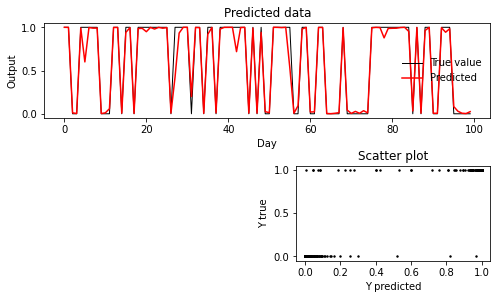

mse=0.03
r2=0.88


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#
# Show results
#
plt.figure(figsize=(8,7))


plt.subplot(3, 1, 1)
plt.plot(target[0:100], color = 'black', linewidth=1, label = 'True value')
plt.plot(prediction[0:100], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Output")
plt.xlabel("Day")
plt.title("Predicted data")

plt.subplot(3, 2, 4)
plt.scatter(prediction, target, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(target, prediction)
r2 = r2_score(target, prediction)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))    


# Serving

In [15]:
! docker run -d --rm -p 8501:8501 \
    -v "$_serving_model_dir:/models/model" \
    -e MODEL_NAME=model \
    --name serving_model \
    tensorflow/serving

25bdbe21691fa99982ecbc633b143dbebf36c718f4ea753371cff42d04ba10e0


In [16]:
import time
time.sleep(5)

! curl http://localhost:8501/v1/models/model   

{
 "model_version_status": [
  {
   "version": "1615314210",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}


In [17]:
import sys  
sys.path.append("../product_price_lstm") 

In [18]:
# Create prediction from a csv file (the entire dataset, eval and train)
import requests
from ts_csv_example_gen import Encoder

schema_path = os.path.join(schema_gen.outputs['schema'].get()[0].uri,'schema.pbtxt')

e = Encoder(schema_path=schema_path)

encoded_examples = e.serialize_and_encode_from_csv(
    input_path=_data_dir,
    ts_window=1, 
    return_list=True
    )

print("Len:",len(encoded_examples))

instances = []

for row in encoded_examples:
    instances.append({"examples":{"b64": row}})

r = requests.post(
    f'http://localhost:8501/v1/models/model:predict',
    json={"instances":instances}
)

r.json()

output path: '/tmp/tmp4rpo1jsv'
INFO:absl:Processing input csv data /home/borlogh/Azumo/Stovell/MLOps/tfx_local/titanic/../../data/titanic/* to TFExample.
Len: 1305


{'predictions': [0.999830544,
  0.886521935,
  0.0519012809,
  0.00237563252,
  0.0476645529,
  0.987581074,
  0.998912632,
  0.0108940601,
  0.999114871,
  0.00377044082,
  0.0135843158,
  0.998233318,
  0.998670518,
  0.99174583,
  0.599845111,
  0.00966471434,
  0.00540035963,
  0.997042656,
  0.999248,
  0.123875827,
  0.990144074,
  0.999632418,
  0.991679311,
  0.99904871,
  0.997156441,
  0.00539156795,
  0.9907884,
  0.999675572,
  0.996869564,
  0.961684167,
  0.00288558,
  0.99293983,
  0.997579575,
  0.997768104,
  0.00377348065,
  0.999744296,
  0.998243928,
  0.992115617,
  0.00273838639,
  0.0108100772,
  0.0586681068,
  0.997927427,
  0.998228908,
  0.999808073,
  0.999834716,
  0.00367870927,
  0.00803482533,
  0.941558123,
  0.995507598,
  0.99579227,
  0.999957204,
  0.00134855509,
  0.00221854448,
  0.00440299511,
  0.98776722,
  0.999279082,
  0.948956132,
  0.999321163,
  0.0101726949,
  0.999137044,
  0.00160351396,
  0.985886,
  0.00139066577,
  0.987936616,
  0.

In [19]:
# Create prediction from TFrecord (dataset eval)
import requests
from ts_csv_example_gen import Encoder

input_path = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'eval')

e = Encoder()

encoded_examples = e.serialize_and_encode_from_tfrecord(
    input_path=input_path,
    return_list=True
    )

print("Len:",len(encoded_examples))

instances = []

for row in encoded_examples:
    instances.append({"examples":{"b64": row}})

r = requests.post(
    f'http://localhost:8501/v1/models/model:predict',
    json={"instances":instances}
)

r.json()


output path: '/tmp/tmpb8vu18kn'
Len: 429


{'predictions': [0.999830544,
  0.998912632,
  0.0108940601,
  0.00377044082,
  0.99174583,
  0.599845111,
  0.997042656,
  0.990144074,
  0.9907884,
  0.00288558,
  0.0108100772,
  0.0586681068,
  0.997927427,
  0.998228908,
  0.00803482533,
  0.941558123,
  0.99579227,
  0.00440299511,
  0.985886,
  0.987936616,
  0.94903928,
  0.99831748,
  0.979990482,
  0.998819947,
  0.989545524,
  0.995436966,
  0.00838667154,
  0.424464822,
  0.933610201,
  0.999660075,
  0.999894142,
  0.199371397,
  0.99803865,
  0.995553792,
  0.00560125709,
  0.919895947,
  0.998553514,
  0.0108895302,
  0.979602277,
  0.99910444,
  0.999493957,
  0.999838114,
  0.718494,
  0.99751246,
  0.998976946,
  0.00793036819,
  0.991128385,
  0.00789961219,
  0.941811681,
  0.0247564316,
  0.0127899051,
  0.999878883,
  0.999243379,
  0.996294,
  0.99965483,
  0.532254398,
  0.0062957406,
  0.0929727256,
  0.98014909,
  0.999270737,
  0.0205848813,
  0.022492826,
  0.998102665,
  0.998223722,
  0.003495574,
  0.0011

In [20]:
! docker stop serving_model

serving_model
